In [1]:
from couplevae import *
import scanpy as sc
# 环境配置与包导入
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')  # 如果你在 Notebook 中想显示图，可以注释掉这一行
from scipy.sparse import issparse
from scipy import sparse
from adjustText import adjust_text

from couplevae import *  # 确保你已经正确安装了 couplevae


In [2]:
# adata=sc.read('/data/CoupleVAE-master/data/train_covid.h5ad')

In [3]:
# adata.obs['celltype'].value_counts()

In [4]:
# 路径与参数设置
train_path = "F:\研0\新论文\构建单细胞因果推断模型\CoupleVAE-master\data\\train\\train_covid.h5ad"
valid_path = "F:\研0\新论文\构建单细胞因果推断模型\CoupleVAE-master\data/valid_covid.h5ad"
test_path = "F:\研0\新论文\构建单细胞因果推断模型\CoupleVAE-master\data/test_covid.h5ad"

In [5]:
# 加载 AnnData 数据
train = sc.read(train_path)
valid = sc.read(valid_path)
test = sc.read(test_path)


In [6]:
train

AnnData object with n_obs × n_vars = 9426 × 6000
    obs: 'condition', 'celltype', 'batch'

In [7]:
train.obs['celltype'].value_counts()

Macrophages    4318
Neutrophil     2566
NK             1068
Secretory       616
mDC             536
CD8 T           322
Name: celltype, dtype: int64

In [8]:
valid.obs['celltype'].value_counts()

Macrophages    520
Neutrophil     334
NK             134
Secretory      102
mDC             62
CD8 T           52
Name: celltype, dtype: int64

In [9]:
data_name = "COVID-19"
cell_type = "Macrophages"
condition_key = "condition"
cell_type_key = "celltype"
pert_key = "severe COVID-19"
ctrl_key = "control"
device = "cuda"  # 如果没有 GPU 可以设置为 "cpu"

In [10]:
trainloader = load_h5ad_to_dataloader(train, condition_key, cell_type_key, 
                                       cell_type, ctrl_key, pert_key, device)
validloader = load_h5ad_to_dataloader(valid, condition_key, cell_type_key, 
                                       cell_type, ctrl_key, pert_key, device)


In [11]:
len(validloader)

16

In [12]:
len(trainloader)

134

In [13]:
network = VAE(x_dim=train.X.shape[1],
              z_dim=200,
              alpha=0.00005,
              beta=0.05,
              dropout_rate=0.1,
              learning_rate=0.0001)

trainer = Trainer(model=network, learning_rate=0.0001, n_epochs=200, patience=20, batch_size=64)

# 训练模型
trainer.train(train_loader=trainloader, valid_loader=validloader)


d:\anaconda\envs\couplevae_env\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
d:\anaconda\envs\couplevae_env\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1, Train Loss: 605.4276, Validation Loss: 532.3940
Epoch 2, Train Loss: 512.3429, Validation Loss: 500.4050
Epoch 3, Train Loss: 494.6023, Validation Loss: 487.3660
Epoch 4, Train Loss: 479.8834, Validation Loss: 473.8777
Epoch 5, Train Loss: 469.6122, Validation Loss: 466.7032
Epoch 6, Train Loss: 461.3426, Validation Loss: 460.6208
Epoch 7, Train Loss: 454.9398, Validation Loss: 456.6701
Epoch 8, Train Loss: 449.0712, Validation Loss: 452.6760
Epoch 9, Train Loss: 443.2157, Validation Loss: 448.9990
Epoch 10, Train Loss: 438.3232, Validation Loss: 446.0815
Epoch 11, Train Loss: 433.9445, Validation Loss: 444.0498
Epoch 12, Train Loss: 428.4830, Validation Loss: 438.1422
Epoch 13, Train Loss: 421.3694, Validation Loss: 435.8398
Epoch 14, Train Loss: 417.2375, Validation Loss: 433.8935
Epoch 15, Train Loss: 412.9978, Validation Loss: 432.2092
Epoch 16, Train Loss: 409.4587, Validation Loss: 430.9234
Epoch 17, Train Loss: 405.4208, Validation Loss: 430.8803
Epoch 18, Train Loss: 4

In [14]:
test = train.concatenate(valid,test)
test_adata_c = test[(test.obs[condition_key]==ctrl_key)&(test.obs[cell_type_key]==cell_type)]  
test_adata_p = test[(test.obs[condition_key]==pert_key)&(test.obs[cell_type_key]==cell_type)]

C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_33956\2947287477.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  test = train.concatenate(valid,test)


In [15]:
pred = network.predict(test_adata_c, test_adata_p)

# 包装为 AnnData
pred_adata = anndata.AnnData(pred, 
                             obs={condition_key: [f"{cell_type}_pred_pert"] * len(pred),
                                  cell_type_key: [cell_type] * len(pred)},
                             var={"var_names": test_adata_c.var_names})

if sparse.issparse(test_adata_c.X):
    test_adata_c.X = test_adata_c.X.A
ctrl_adata = anndata.AnnData(test_adata_c.X,
                             obs={condition_key: [f"{cell_type}_ctrl"] * len(test_adata_c),
                                  cell_type_key: [cell_type] * len(test_adata_c)},
                             var={"var_names": test_adata_c.var_names})

if sparse.issparse(test_adata_p.X):
    test_adata_p.X = test_adata_p.X.A
real_stim_adata = anndata.AnnData(test_adata_p.X,
                                  obs={condition_key: [f"{cell_type}_real_pert"] * len(test_adata_p),
                                       cell_type_key: [cell_type] * len(test_adata_p)},
                                  var={"var_names": test_adata_p.var_names})

# 合并结果保存
all_data = ctrl_adata.concatenate(pred_adata, real_stim_adata)
all_data.write_h5ad(f"./coupleVAE{data_name}_{cell_type}.h5ad")


C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_33956\204310225.py:24: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_data = ctrl_adata.concatenate(pred_adata, real_stim_adata)


In [16]:
if sparse.issparse(test_adata_c.X):
    test_adata_c.X = test_adata_c.X.A
ctrl_adata = anndata.AnnData(test_adata_c.X,
                             obs={condition_key: [f"{cell_type}_ctrl"] * len(test_adata_c),
                                  cell_type_key: [cell_type] * len(test_adata_c)},
                             var={"var_names": test_adata_c.var_names})

if sparse.issparse(test_adata_p.X):
    test_adata_p.X = test_adata_p.X.A
real_stim_adata = anndata.AnnData(test_adata_p.X,
                                  obs={condition_key: [f"{cell_type}_real_pert"] * len(test_adata_p),
                                       cell_type_key: [cell_type] * len(test_adata_p)},
                                  var={"var_names": test_adata_p.var_names})

# 合并结果保存
all_data = ctrl_adata.concatenate(pred_adata, real_stim_adata)
all_data.write_h5ad(f"./coupleVAE{data_name}_{cell_type}.h5ad")

C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_33956\3814496317.py:16: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_data = ctrl_adata.concatenate(pred_adata, real_stim_adata)


In [17]:
# def plot_gene_correlation(data, cond_col, axes_map, label_map, file_path='./output_plot.pdf', 
#                           genes_of_interest=None, top_genes=None, show_plot=False, include_legend=True, 
#                           plot_title='', x_offset=0.3, y_offset=0.8, text_size=14):
#     if genes_of_interest is None:
#         genes_of_interest = []
#     if top_genes is None:
#         top_genes = []

#     if issparse(data.X):
#         data.X = data.X.toarray()

#     group_y = data[data.obs[cond_col] == axes_map['y'], :]
#     group_x = data[data.obs[cond_col] == axes_map['x'], :]

#     if len(top_genes) > 0:
#         subset_data_x = group_x[:, top_genes].X
#         subset_data_y = group_y[:, top_genes].X
#         avg_x_genes = np.mean(subset_data_x, axis=0)
#         avg_y_genes = np.mean(subset_data_y, axis=0)
#         r_squared_top = np.corrcoef(avg_x_genes, avg_y_genes)[0, 1] ** 2
#         print(f'R-squared for top genes: {r_squared_top:.2f}')

#     avg_x = np.mean(group_x.X, axis=0)
#     avg_y = np.mean(group_y.X, axis=0)
#     r_squared_all = np.corrcoef(avg_x, avg_y)[0, 1] ** 2
#     print(f'R-squared for all genes: {r_squared_all:.2f}')

#     df = pd.DataFrame({label_map['x']: avg_x, label_map['y']: avg_y})
#     plt.figure()
#     ax = sns.regplot(x=label_map['x'], y=label_map['y'], data=df, scatter_kws={'s': 10}, line_kws={'color': 'green'})
#     plt.xlabel(label_map['x'], fontsize=text_size)
#     plt.ylabel(label_map['y'], fontsize=text_size)

#     if plot_title:
#         plt.title(plot_title, fontsize=text_size)

#     if len(genes_of_interest) > 0:
#         texts = []
#         for gene in genes_of_interest:
#             gene_idx = np.where(data.var_names == gene)[0][0]
#             x_pos = avg_x[gene_idx]
#             y_pos = avg_y[gene_idx]
#             texts.append(plt.text(x_pos, y_pos, gene, fontsize=10, color='black'))
#             plt.scatter(x_pos, y_pos, color='red', s=40)
#         adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey', lw=0.5))

#     plt.text(max(avg_x) - max(avg_x) * x_offset, max(avg_y) - y_offset * max(avg_y),
#              r'$\mathrm{R^2_{\mathrm{\mathsf{all\ genes}}}}$='+ f"{r_squared_all:.2f}", fontsize=text_size)

#     if len(top_genes) > 0:
#         plt.text(max(avg_x) - max(avg_x) * x_offset, max(avg_y) - (y_offset + 0.15) * max(avg_y),
#                 r'$\mathrm{R^2_{\mathrm{\mathsf{top\ 100\ DEGs}}}}$='+ f"{r_squared_top:.2f}", fontsize=text_size)

#     if include_legend:
#         plt.legend(loc='best')

#     plt.savefig(file_path, bbox_inches='tight', dpi=300)
#     if show_plot:
#         plt.show()
#     plt.close()


In [18]:
def plot_gene_correlation(data, cond_col, axes_map, label_map, file_path='./output_plot.pdf', 
                          genes_of_interest=None, top_genes=None, show_plot=False, include_legend=True, 
                          plot_title='', x_offset=0.05, y_offset=0.95, text_size=14, reg_type='mean'):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from adjustText import adjust_text
    from scipy.sparse import issparse

    sns.set(style="white", context="notebook")  # 或 'talk', 'paper'
    plt.rcParams['axes.linewidth'] = 1.2  # 坐标轴线宽
    plt.rcParams['xtick.major.width'] = 1.2
    plt.rcParams['ytick.major.width'] = 1.2

    if genes_of_interest is None:
        genes_of_interest = []
    if top_genes is None:
        top_genes = []

    if issparse(data.X):
        data.X = data.X.toarray()

    group_y = data[data.obs[cond_col] == axes_map['y'], :]
    group_x = data[data.obs[cond_col] == axes_map['x'], :]

    # 选择均值或方差
    if reg_type == 'mean':
        avg_func = np.mean
    elif reg_type == 'var':
        avg_func = np.var
    else:
        raise ValueError("reg_type must be 'mean' or 'var'")

    r_squared_top = None
    if len(top_genes) > 0:
        subset_data_x = group_x[:, top_genes].X
        subset_data_y = group_y[:, top_genes].X
        avg_x_genes = avg_func(subset_data_x, axis=0)
        avg_y_genes = avg_func(subset_data_y, axis=0)
        r_squared_top = np.corrcoef(avg_x_genes, avg_y_genes)[0, 1] ** 2
        print(f'R-squared for top genes: {r_squared_top:.2f}')

    avg_x = avg_func(group_x.X, axis=0)
    avg_y = avg_func(group_y.X, axis=0)
    r_squared_all = np.corrcoef(avg_x, avg_y)[0, 1] ** 2
    print(f'R-squared for all genes: {r_squared_all:.2f}')

    df = pd.DataFrame({label_map['x']: avg_x, label_map['y']: avg_y})

    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.regplot(x=label_map['x'], y=label_map['y'], data=df,
                scatter_kws={'s': 60, 'alpha': 0.5},
                line_kws={'color': 'green'}, ax=ax)

    # from sklearn.ensemble import RandomForestRegressor

    # # 画散点
    # ax.scatter(df[label_map['x']], df[label_map['y']], s=60, alpha=0.5)

    # # 拟合随机森林
    # rf = RandomForestRegressor(n_estimators=100, random_state=0)
    # rf.fit(df[[label_map['x']]], df[label_map['y']])

    # # 构造拟合曲线点
    # x_range = np.linspace(df[label_map['x']].min(), df[label_map['x']].max(), 500).reshape(-1, 1)
    # y_pred = rf.predict(x_range)

    # # 绘制拟合曲线
    # ax.plot(x_range, y_pred, color='green', label='Random Forest Fit')



    ax.set_xlabel(label_map['x'], fontsize=text_size)
    ax.set_ylabel(label_map['y'], fontsize=text_size)
    ax.grid(False)

    if plot_title:
        ax.set_title(plot_title, fontsize=text_size)

    # 标注基因
    texts = []
    for gene in genes_of_interest[:10]:
        if gene in data.var_names:
            gene_idx = np.where(data.var_names == gene)[0][0]
            x_pos = avg_x[gene_idx]
            y_pos = avg_y[gene_idx]
            texts.append(ax.text(x_pos, y_pos, gene, fontsize=10, color='black'))
            ax.scatter(x_pos, y_pos, color='red', s=60, zorder=3)
    if texts:
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.6))

    # 使用 ax.transAxes 保证一致位置
    ax.text(x_offset, y_offset,
            r'$R^2_{\mathrm{all\ genes}}$' + f" = {r_squared_all:.2f}",
            transform=ax.transAxes, fontsize=text_size)

    if r_squared_top is not None:
        ax.text(x_offset, y_offset - 0.1,
                r'$R^2_{\mathrm{top\ 100\ DEGs}}$' + f" = {r_squared_top:.2f}",
                transform=ax.transAxes, fontsize=text_size)

    if include_legend:
        ax.legend(loc='best')

    plt.tight_layout()
    if file_path:
        plt.savefig(file_path, bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    plt.close()


R-squared for top genes: 0.99
R-squared for all genes: 0.99


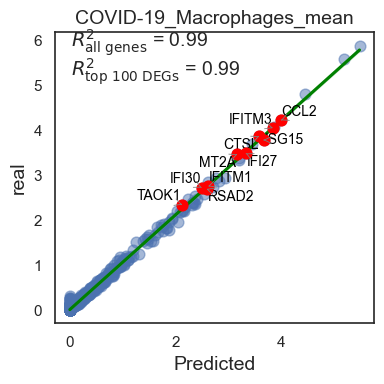

R-squared for top genes: 0.92
R-squared for all genes: 0.85


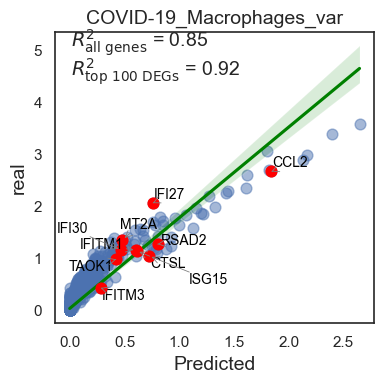

In [19]:
%matplotlib inline
result = sc.read(f"./coupleVAECOVID-19_{cell_type}.h5ad")

sc.tl.rank_genes_groups(result, groupby="condition", n_genes=100, method="wilcoxon")

diff_genes_covid = result.uns["rank_genes_groups"]["names"][f"{cell_type}_real_pert"]

conditions = {
    "ctrl": f"{cell_type}_ctrl",
    "pred_stim": f"{cell_type}_pred_pert",
    "real_stim": f"{cell_type}_real_pert"
}
plot_gene_correlation(data=result,
                      cond_col="condition",
                      axes_map={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                      label_map={"x": "Predicted", "y": "real"},
                      genes_of_interest=diff_genes_covid[:10],
                      top_genes=diff_genes_covid,
                      reg_type='mean',  # 或 'var'
                      plot_title=f"{data_name}_{cell_type}_mean",
                      show_plot=True,
                    #   fontsize=12,
                      include_legend=False)
plot_gene_correlation(data=result,
                      cond_col="condition",
                      axes_map={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                      label_map={"x": "Predicted", "y": "real"},
                      genes_of_interest=diff_genes_covid[:10],
                      top_genes=diff_genes_covid,
                      reg_type='var',  # 或 'var'
                      plot_title=f"{data_name}_{cell_type}_var",
                      show_plot=True,
                    #   fontsize=12,
                      include_legend=False)

In [20]:
result.obs['condition']

0-0            Macrophages_ctrl
1-0            Macrophages_ctrl
2-0            Macrophages_ctrl
3-0            Macrophages_ctrl
4-0            Macrophages_ctrl
                  ...          
2662-2    Macrophages_real_pert
2663-2    Macrophages_real_pert
2664-2    Macrophages_real_pert
2665-2    Macrophages_real_pert
2666-2    Macrophages_real_pert
Name: condition, Length: 8001, dtype: category
Categories (3, object): ['Macrophages_ctrl', 'Macrophages_pred_pert', 'Macrophages_real_pert']

In [21]:
groups  = result.uns['rank_genes_groups']['names'].dtype.names
groups

('Macrophages_ctrl', 'Macrophages_pred_pert', 'Macrophages_real_pert')

In [22]:
import pandas as pd

# 假设 AnnData 对象是 adata，已经运行过 scanpy.tl.rank_genes_groups

# 替换为你感兴趣的 celltype 或 group 名
target_group = "Macrophages_pred_pert"  # 修改为你实际使用的分组名

# 提取数据
genes = result.uns['rank_genes_groups']['names'][target_group]
logfc = result.uns['rank_genes_groups']['logfoldchanges'][target_group]
print(len(genes))
# 构建 DataFrame
df = pd.DataFrame({
    'gene': genes,
    'logFC': logfc
})

# 可选：筛选显著差异表达（如 abs(logFC) > 1）
# df = df[abs(df['logFC']) > 1]

# 保存为 CSV
df.to_csv("differential_genes_logFC.csv", index=False)

# 或保存为 Excel（可选）
# df.to_excel("differential_genes_logFC.xlsx", index=False)

print("已保存为 differential_genes_logFC.csv")


100
已保存为 differential_genes_logFC.csv


In [23]:
gene_sets = {}
for gpname in groups:
    genes = result.uns['rank_genes_groups']['names'][gpname][:200]  # 前 200 基因
    gene_sets[gpname] = genes.tolist()

In [24]:
result.uns['rank_genes_groups']['names']

rec.array([('C1QA', 'PRKCB', 'IFITM3'), ('FABP4', 'SIAH2', 'IFI30'),
           ('TMSB4X', 'MARCH7', 'CTSL'), ('RPL26', 'TRMT1', 'TAOK1'),
           ('HLA-DPB1', 'DUSP5', 'MT2A'), ('RPL13A', 'RALGDS', 'IFITM1'),
           ('APOE', 'HIST1H2AC', 'ISG15'), ('ALOX5AP', 'IDH2', 'IFI27'),
           ('VSIG4', 'CPD', 'RSAD2'), ('RPL31', 'H1F0', 'CCL2'),
           ('RPS6', 'TRIB1', 'H3F3B'), ('C1QC', 'ZSWIM6', 'IFIT3'),
           ('LYZ', 'IFRD1', 'IFIT1'), ('STMN1', 'IRAK3', 'IFITM2'),
           ('INHBA', 'TAB2', 'SAT1'), ('RPL21', 'MIR22HG', 'IFIT2'),
           ('LPL', 'MSL1', 'TNFSF10'), ('SCD', 'RNF11', 'MALAT1'),
           ('TREM2', 'LBR', 'CXCL10'), ('AKR1B1', 'DOCK4', 'NEAT1'),
           ('GPR34', 'MBOAT7', 'CCL8'),
           ('GPNMB', 'CSGALNACT2', 'C15orf48'),
           ('GPX3', 'METTL9', 'FTH1'), ('SPARC', 'CWC25', 'APOBEC3A'),
           ('TFRC', 'APP', 'IL1RN'), ('A2M', 'BCL3', 'SRGN'),
           ('CD52', 'HES4', 'TIMP1'), ('MRC1', 'STX3', 'NCF1'),
           ('APMAP', 'A

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
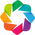

      celltype    gene
0  Macrophages   PRKCB
1  Macrophages   SIAH2
2  Macrophages  MARCH7
3  Macrophages   TRMT1
4  Macrophages   DUSP5


:Chord   [source,target]   (count)

In [25]:
import pandas as pd
import plotly.graph_objects as go
import holoviews as hv
from holoviews import opts

# 确保启用 bokeh 可视化
hv.extension('bokeh')

# 假设 AnnData 对象已经加载为 adata

# ① 获取每个细胞类型的 top 100 基因
top_genes = {}
for cell_type in result.obs['celltype'].unique():
    # 从 rank_genes_groups 中提取每个 celltype 对应的 top 100 基因
    top_genes[cell_type] = result.uns['rank_genes_groups']['names']["Macrophages_pred_pert"][:10]

# 转换为 DataFrame
top_genes_df = pd.DataFrame([
    (cell_type, gene) for cell_type, genes in top_genes.items() for gene in genes
], columns=['celltype', 'gene'])

# 显示 top 基因数据
print(top_genes_df.head())

# ② 为 Sankey 图准备数据

# 计算基因与细胞类型的频数（即该基因在某个细胞类型下的表达量）
df = top_genes_df.groupby(['celltype', 'gene']).size().reset_index(name='count')

# ③ 为基因和细胞类型创建唯一索引
labels = pd.concat([df['celltype'], df['gene']]).unique()
label_id = {name: i for i, name in enumerate(labels)}

# ④ 构建 Sankey 图链接：基因 ➜ 细胞类型
def build_links(src_col, tgt_col):
    grp = df.groupby([src_col, tgt_col])['count'].sum().reset_index()
    return dict(
        source=grp[src_col].map(label_id),
        target=grp[tgt_col].map(label_id),
        value=grp['count']
    )

links = build_links('gene', 'celltype')

# ⑤ 绘制 Sankey 图
sankey = go.Sankey(
    node=dict(label=labels, pad=15, thickness=15),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value']
    )
)

fig = go.Figure(sankey)
fig.update_layout(width=900, height=600)
# fig.write_image("sankey_top_genes.png", width=900, height=600)
fig.show()


# ② 为 Chord 图准备数据
# 转换为边列表：[source, target, value]
edges = top_genes_df.groupby(['gene', 'celltype']).size().reset_index(name='count')
edges = edges[edges['count'] > 0]

# ③ 构建节点
nodes = list(set(edges['gene']).union(set(edges['celltype'])))
nodes_df = pd.DataFrame({'name': nodes})

# ④ 创建节点 ID 映射
node_id = {name: i for i, name in enumerate(nodes)}
edges['source'] = edges['gene'].map(node_id)
edges['target'] = edges['celltype'].map(node_id)

# ⑤ 构建 Holoviews Chord 对象
chord = hv.Chord((edges[['source', 'target', 'count']], hv.Dataset(nodes_df, 'index')))
chord.opts(
    opts.Chord(cmap='Category20', edge_color='source',
               labels='name', node_color='index', width=600, height=600))


In [26]:
result.uns['rank_genes_groups']['names']

rec.array([('C1QA', 'PRKCB', 'IFITM3'), ('FABP4', 'SIAH2', 'IFI30'),
           ('TMSB4X', 'MARCH7', 'CTSL'), ('RPL26', 'TRMT1', 'TAOK1'),
           ('HLA-DPB1', 'DUSP5', 'MT2A'), ('RPL13A', 'RALGDS', 'IFITM1'),
           ('APOE', 'HIST1H2AC', 'ISG15'), ('ALOX5AP', 'IDH2', 'IFI27'),
           ('VSIG4', 'CPD', 'RSAD2'), ('RPL31', 'H1F0', 'CCL2'),
           ('RPS6', 'TRIB1', 'H3F3B'), ('C1QC', 'ZSWIM6', 'IFIT3'),
           ('LYZ', 'IFRD1', 'IFIT1'), ('STMN1', 'IRAK3', 'IFITM2'),
           ('INHBA', 'TAB2', 'SAT1'), ('RPL21', 'MIR22HG', 'IFIT2'),
           ('LPL', 'MSL1', 'TNFSF10'), ('SCD', 'RNF11', 'MALAT1'),
           ('TREM2', 'LBR', 'CXCL10'), ('AKR1B1', 'DOCK4', 'NEAT1'),
           ('GPR34', 'MBOAT7', 'CCL8'),
           ('GPNMB', 'CSGALNACT2', 'C15orf48'),
           ('GPX3', 'METTL9', 'FTH1'), ('SPARC', 'CWC25', 'APOBEC3A'),
           ('TFRC', 'APP', 'IL1RN'), ('A2M', 'BCL3', 'SRGN'),
           ('CD52', 'HES4', 'TIMP1'), ('MRC1', 'STX3', 'NCF1'),
           ('APMAP', 'A

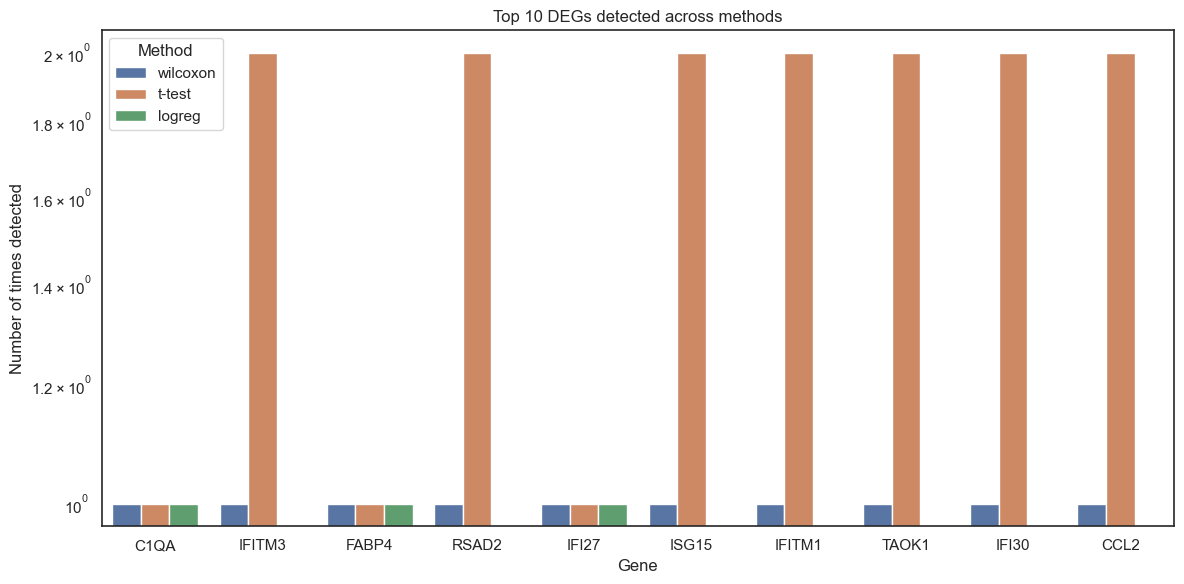

In [27]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

methods = ['wilcoxon', 't-test', 'logreg']
gene_counts = defaultdict(lambda: [0]*len(methods))  # {gene: [count per method]}

# 对所有方法，统计每个方法前10 DEGs
for m_idx, method in enumerate(methods):
    # 运行差异表达（假设 condition 有两个组，如 drug vs control）
    sc.tl.rank_genes_groups(result, groupby='condition', method=method)
    
    # 提取所有组的前10个基因（你也可以只对一个组感兴趣）
    groups = result.uns['rank_genes_groups']['names'].dtype.names
    
    for group in groups:
        top_genes = result.uns['rank_genes_groups']['names'][group][:10]
        for gene in top_genes:
            gene_counts[gene][m_idx] += 1

# 转为 DataFrame
df = pd.DataFrame(gene_counts, index=methods).T
df.columns = methods

# 只取在至少一个方法中出现过的前10个基因
top10_genes = df.sum(axis=1).sort_values(ascending=False).head(10).index
df = df.loc[top10_genes]

# 画堆叠柱状图
df_plot = df.reset_index().melt(id_vars='index', var_name='Method', value_name='Count')
df_plot.rename(columns={'index': 'Gene'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x='Gene', y='Count', hue='Method')
plt.yscale('log')  # 如果范围大可选，不需要就去掉
plt.title('Top 10 DEGs detected across methods')
plt.ylabel('Number of times detected')
plt.xlabel('Gene')
plt.legend(title='Method')
plt.tight_layout()
plt.show()


In [28]:
import scanpy as sc
import numpy as np
import pandas as pd
from collections import Counter

# 假设你关心的是 "Macrophages"
celltype = "mDC"
adata_sub = result[result.obs["celltype"] == celltype].copy()

# 查看有几个 condition
print(adata_sub.obs["condition"].value_counts())


Series([], Name: condition, dtype: int64)


In [29]:
# 分别取出两组
ctrl = adata_sub[adata_sub.obs['condition'] == 'mDC_ctrl']
severe = adata_sub[adata_sub.obs['condition'] == 'mDC_pred_pert']
ctrl,severe

(View of AnnData object with n_obs × n_vars = 0 × 6000
     obs: 'condition', 'celltype', 'batch'
     uns: 'rank_genes_groups',
 View of AnnData object with n_obs × n_vars = 0 × 6000
     obs: 'condition', 'celltype', 'batch'
     uns: 'rank_genes_groups')

In [30]:
import numpy as np
import scanpy as sc
from collections import Counter

def run_de_pseudorep_multi(
    adata_sub,
    de_methods=["wilcoxon", "t-test", "logreg"],
    group1="mDC_real_pert",
    group2="mDC_ctrl",
    n_cells=20,
    n_replicates=3,
    top_n_genes=100,
    random_state=0
):
    np.random.seed(random_state)
    results = {}
    
    group1_data = adata_sub[adata_sub.obs["condition"] == group1]
    group2_data = adata_sub[adata_sub.obs["condition"] == group2]

    if group1_data.n_obs < n_cells or group2_data.n_obs < n_cells:
        raise ValueError(f"Not enough cells in group1 ({group1_data.n_obs}) or group2 ({group2_data.n_obs})")

    for method in de_methods:
        gene_sets = []

        for _ in range(n_replicates):
            idx1 = np.random.choice(group1_data.obs_names, size=n_cells, replace=False)
            idx2 = np.random.choice(group2_data.obs_names, size=n_cells, replace=False)
            replicate = adata_sub[idx1.tolist() + idx2.tolist()].copy()

            # 替换为新 group：real_pert vs ctrl
            replicate.obs['group'] = replicate.obs['condition'].map({
                group1: 'real',
                group2: 'ctrl'
            })

            sc.tl.rank_genes_groups(
                replicate,
                groupby='group',
                groups=['real'],
                reference='ctrl',
                method=method
            )

            genes = replicate.uns['rank_genes_groups']['names']['real'][:top_n_genes]
            gene_sets.append(set(genes))

        # 统计重复次数
        all_genes = sum([list(g) for g in gene_sets], [])
        counts = Counter(all_genes)
        replicated = [g for g, c in counts.items() if c >= 2]
        unique = [g for g, c in counts.items() if c == 1]

        results[method] = {
            'replicated': len(replicated),
            'unique': len(unique),
            'replication_rate': round(len(replicated) / (len(replicated) + len(unique) + 1e-6), 2)
        }

    return results


In [31]:
# 假设你已经 subset 到 celltype == 'mDC'
adata_sub = result[result.obs['celltype'] == 'mDC'].copy()

res = run_de_pseudorep_multi(
    adata_sub,
    de_methods=['wilcoxon', 't-test', 'logreg'],
    group1='mDC_pred_pert',
    group2='mDC_ctrl',
    n_cells=20,
    n_replicates=3,
    top_n_genes=100
)


ValueError: Not enough cells in group1 (0) or group2 (0)

In [ ]:
%config InlineBackend.figure_format = 'retina'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

methods = list(res.keys())
replicated = [res[m]['replicated'] for m in methods]
unique     = [res[m]['unique'] for m in methods]
rate       = [res[m]['replication_rate'] for m in methods]

x = np.arange(len(methods))
fig, ax = plt.subplots(figsize=(8, 5))

bar1 = ax.bar(x, replicated, color='#00bfc4', label='No. replicated')
bar2 = ax.bar(x, unique, bottom=replicated, color='#f8766d', label='No. unique')

for i in range(len(methods)):
    ax.text(x[i], replicated[i]/2, f"{rate[i]:.2f}", ha='center', va='center', fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45)
ax.set_ylabel('Number of DEGs')
ax.set_xlabel('DE method')
ax.set_title('Replicated vs Unique DEGs (mDC_real_pert vs ctrl)')
ax.legend(loc='upper right', frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
# 假设你已经 subset 到 celltype == 'mDC'
adata_sub = result[result.obs['celltype'] == 'mDC'].copy()

res = run_de_pseudorep_multi(
    adata_sub,
    de_methods=['wilcoxon', 't-test', 'logreg'],
    group1='mDC_real_pert',
    group2='mDC_ctrl',
    n_cells=20,
    n_replicates=3,
    top_n_genes=100
)


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline

# 设置图像大小、字体等参数（全局控制）
sc.set_figure_params(figsize=(4, 4), dpi=100, fontsize=10)

# 运行 PCA
sc.tl.pca(result)

# 绘制 PCA 概览图
sc.pl.pca_overview(
    result,
    color="condition",
    ncols=2,
    size=10,
    show=True
)


In [ ]:
adata=sc.read('/data/CoupleVAE-master/data/train_covid.h5ad')
sc.pp.neighbors(adata,n_neighbors=50)
sc.tl.umap(adata)
sc.pl.umap(adata, 
           color='celltype', 
           wspace=0.5,
           palette=sc.pl.palettes.godsnot_102,
           frameon=False)

In [ ]:
adata

In [ ]:
# adata=sc.read('/data/CoupleVAE-master/data/train_covid.h5ad')
# sc.pp.neighbors(adata,n_neighbors=50)
# sc.tl.umap(adata)
sc.pl.umap(adata, 
           color='condition', 
           wspace=0.5,
           palette=['#3da5d9', '#49a078'],
           frameon=False)

In [ ]:
# import scanpy as sc
# import matplotlib.pyplot as plt

# adata = sc.read('/data/CoupleVAE-master/data/train_covid.h5ad')
# sc.pp.neighbors(adata, n_neighbors=30)
# sc.tl.umap(adata)

# # 返回图对象
# fig = sc.pl.umap(
#     adata,
#     color='celltype',
#     wspace=0.1,
#     palette=sc.pl.palettes.godsnot_102,
#     frameon=False,
#     return_fig=True  # 获取 matplotlib 的 fig
# )

# # # 设置所有子图的长宽比例为1（圆形）
# # for ax in fig.axes:
# #     ax.set_aspect('equal')

# plt.show()


In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc
sc.pp.neighbors(result, n_neighbors=30)
sc.tl.umap(result)
# 绘制 UMAP 图
sc.pl.umap(
    result,
    color='condition',
    frameon=False,
    wspace=0.5,
    palette=['#3da5d9', '#49a078', '#f26a8d'],
    size=30,
    show=False  # 不立即显示
)

# 获取当前图像和坐标轴对象
ax = plt.gca()

# 加粗标题
ax.set_title(ax.get_title(), fontsize=14, fontweight='bold')

# 加粗坐标轴刻度
ax.tick_params(axis='both', labelsize=11)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# 移动并加粗图例到下方
legend = ax.get_legend()
if legend is not None:
    legend.set_title(legend.get_title().get_text(), prop={'weight': 'bold'})
    for text in legend.get_texts():
        text.set_fontweight('bold')

    # 设置图例位置在下方中央
    legend.set_bbox_to_anchor((0.5, -0.3))  # 横向中心，纵向略低于图
    legend.set_loc("lower center")

# 显示图像
plt.tight_layout()
plt.show()


In [ ]:



pred = network.predict(test_adata_c, test_adata_p)

# 包装为 AnnData
pred_adata = anndata.AnnData(pred, 
                             obs={condition_key: [f"{cell_type}_pred_pert"] * len(pred),
                                  cell_type_key: [cell_type] * len(pred)},
                             var={"var_names": test_adata_c.var_names})

if sparse.issparse(test_adata_c.X):
    test_adata_c.X = test_adata_c.X.A
ctrl_adata = anndata.AnnData(test_adata_c.X,
                             obs={condition_key: [f"{cell_type}_ctrl"] * len(test_adata_c),
                                  cell_type_key: [cell_type] * len(test_adata_c)},
                             var={"var_names": test_adata_c.var_names})

if sparse.issparse(test_adata_p.X):
    test_adata_p.X = test_adata_p.X.A
real_stim_adata = anndata.AnnData(test_adata_p.X,
                                  obs={condition_key: [f"{cell_type}_real_pert"] * len(test_adata_p),
                                       cell_type_key: [cell_type] * len(test_adata_p)},
                                  var={"var_names": test_adata_p.var_names})
print(ctrl_adata.shape)
print(pred_adata.shape)
print(real_stim_adata.shape)
print(all_data.shape)

# 合并结果保存
all_data = ctrl_adata.concatenate(pred_adata, real_stim_adata)
all_data.write_h5ad(f"./coupleVAE{data_name}_{cell_type}.h5ad")


In [ ]:
from scipy.stats import wasserstein_distance, ks_2samp
import numpy as np

def get_gene_expr(adata, gene, condition, condition_key='condition'):
    gene_idx = adata.var_names.get_loc(gene)
    expr = adata[adata.obs[condition_key] == condition].X[:, gene_idx]
    return np.asarray(expr).ravel()

def compute_wasserstein(adata, gene, real_label, pred_label, condition_key='condition'):
    real_expr = get_gene_expr(adata, gene, real_label, condition_key)
    pred_expr = get_gene_expr(adata, gene, pred_label, condition_key)
    return wasserstein_distance(real_expr, pred_expr)

def compute_ks_test(adata, gene, real_label, pred_label, condition_key='condition'):
    real_expr = get_gene_expr(adata, gene, real_label, condition_key)
    pred_expr = get_gene_expr(adata, gene, pred_label, condition_key)
    D, pval = ks_2samp(real_expr, pred_expr)
    return D, pval

def compute_mean_var_diff(adata, gene, real_label, pred_label, condition_key='condition'):
    real = get_gene_expr(adata, gene, real_label, condition_key)
    pred = get_gene_expr(adata, gene, pred_label, condition_key)
    return {
        "mean_diff": abs(np.mean(real) - np.mean(pred)),
        "var_ratio": np.var(pred) / (np.var(real) + 1e-8)
    }


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_violin_compare_pert(adata,
                              genes,
                              condition_key='condition',
                              ctrl_label='Stem_ctrl',
                              real_label='Stem_real_pert',
                              pred_label='Stem_pred_pert',
                              cell_type='Stem',
                              save_path=None,
                              show=True,
                              return_figs=False,
                              figsize=(4, 3),
                              fontsize=12):
    """
    绘制小提琴图，对比 ctrl、真实扰动和预测扰动的表达分布，并显示散点。
    """
    # 筛选三类条件
    valid_labels = [ctrl_label, pred_label, real_label]
    subset = adata[adata.obs[condition_key].isin(valid_labels)]

    figs = []
    for gene in genes:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0.2, 0.2, 0.7, 0.7])
        
        sc.pl.violin(subset,
                     keys=gene,
                     groupby=condition_key,
                     ax=ax,
                     stripplot=True,    # 显示散点
                     jitter=True,       # 增加抖动
                     show=False)
        
        ax.set_title(f'Expression of {gene} in {cell_type}', fontsize=fontsize)
        ax.set_ylabel("Expression", fontsize=fontsize)
        ax.set_xlabel("Condition", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize - 2)
        figs.append(fig)

    # 保存 PDF
    if save_path:
        with PdfPages(save_path) as pdf:
            for fig in figs:
                pdf.savefig(fig, bbox_inches='tight', dpi=300)
                plt.close(fig)

    # 显示
    if show:
        for fig in figs:
            fig.show()

    # 返回对象
    if return_figs:
        return figs


In [ ]:
result.obs

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_violin_compare_pert_joint(adata, genes, ctrl_label, real_label, pred_label,
                                    condition_key='condition', cell_type='Unknown', palette=None, show=True):
    """
    将多个基因的小提琴图绘制在一张图中（按基因合并），用于比较 ctrl/real/pred 三组表达。
    所有文字字体加粗。
    """
    if palette is None:
        palette = {'ctrl': '#a6cee3', 'real': '#1f78b4', 'pred': '#b2df8a'}

    dfs = []
    for gene in genes:
        gene_idx = adata.var_names.get_loc(gene)
        for group, label in zip(['ctrl', 'real', 'pred'], [ctrl_label, real_label, pred_label]):
            sub = adata[adata.obs[condition_key] == label]
            expr = sub.X[:, gene_idx].toarray().flatten() if hasattr(sub.X, "toarray") else sub.X[:, gene_idx].flatten()
            dfs.append(pd.DataFrame({
                'Expression': expr,
                'Group': group,
                'Gene': gene
            }))

    df_all = pd.concat(dfs, axis=0)

    plt.figure(figsize=(1.2 * len(genes), 4))
    ax = sns.violinplot(data=df_all, x='Gene', y='Expression', hue='Group',
                        palette=palette, cut=0, scale='width', inner='quartile')

    # 字体加粗设置
    plt.title(f'{cell_type} Perturbation Expression', fontweight='bold', fontsize=13)
    plt.xlabel('Gene', fontweight='bold', fontsize=11)
    plt.ylabel('Expression', fontweight='bold', fontsize=11)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')

    # 图例加粗
    legend = plt.legend(title='Group', bbox_to_anchor=(1.02, 1), loc='upper left')
    legend.get_title().set_fontweight('bold')
    for text in legend.get_texts():
        text.set_fontweight('bold')

    plt.tight_layout()

    if show:
        plt.show()


In [ ]:
plot_violin_compare_pert_joint(
    result,
    genes=diff_genes_covid[:6],
    ctrl_label='Macrophages_ctrl',
    real_label='Macrophages_real_pert',
    pred_label='Macrophages_pred_pert',
    cell_type='Macrophages'
    
)


In [ ]:
plot_violin_compare_pert(result,
                         genes=diff_genes_covid[:5],
                              ctrl_label='Macrophages_ctrl',
                              real_label='Macrophages_real_pert',
                              pred_label='Macrophages_pred_pert',
                              cell_type='Macrophages',
                        #  save_path='./violin_compare_DEGs.pdf',
                         show=True)


In [ ]:
result.obs

,condition,celltype,batch
0-0,Macrophages_ctrl,Macrophages,0
1-0,Macrophages_ctrl,Macrophages,0
2-0,Macrophages_ctrl,Macrophages,0
3-0,Macrophages_ctrl,Macrophages,0
4-0,Macrophages_ctrl,Macrophages,0
...,...,...,...
2662-2,Macrophages_real_pert,Macrophages,2
2663-2,Macrophages_real_pert,Macrophages,2
2664-2,Macrophages_real_pert,Macrophages,2
2665-2,Macrophages_real_pert,Macrophages,2


In [ ]:
# 差异分析
sc.tl.rank_genes_groups(result, groupby='condition',
                        reference=f'{cell_type}_ctrl', method='wilcoxon')


In [ ]:
cell_type

'Macrophages'

In [ ]:
# 提取 top10 基因（注意匹配你的组名）
true_degs = result.uns['rank_genes_groups']['names']['Macrophages_real_pert'][:10]
pred_degs = result.uns['rank_genes_groups']['names']['Macrophages_pred_pert'][:10]

# 转为 list 方便后续可视化
true_degs = list(true_degs)
pred_degs = list(pred_degs)


In [ ]:
# 提取对应排序值
de_result = result.uns['rank_genes_groups']
group=f'{cell_type}_real_pert'
genes = pd.Series(de_result['names'][group])
scores = pd.Series(de_result['logfoldchanges'][group], index=genes)

# 排序，得到 ranked_gene_list
ranked_gene_list = scores.sort_values(ascending=False)

In [ ]:
import matplotlib.pyplot as plt

# 打分（以真实扰动 top10 为 marker）
sc.tl.score_genes(result, gene_list=true_degs, score_name='stimulated_score')

# 绘图，显示散点，调整大小
plt.figure(figsize=(3, 3))
sc.pl.violin(
    result,
    keys='stimulated_score',
    groupby='condition',
    stripplot=True,        # 显示散点
    size=1.5,              # 控制散点大小
    show=True
)



In [ ]:
import seaborn as sns

# 提取得分和分组信息
df = result.obs[['stimulated_score', 'condition']]

plt.figure(figsize=(3, 3))
sns.boxplot(data=df, x='condition', y='stimulated_score', palette='pastel', width=0.6)
sns.stripplot(data=df, x='condition', y='stimulated_score', color='k', size=1, jitter=True)
plt.ylabel('Stimulated Signature Score')
plt.title('Boxplot of Signature Score')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(4, 3))
for cond in df['condition'].unique():
    subset = df[df['condition'] == cond]['stimulated_score']
    sns.kdeplot(subset, label=cond, fill=True, alpha=0.4)
plt.legend()
plt.title('Density of Stimulated Score')
plt.xlabel('Stimulated Score')
plt.tight_layout()
plt.show()


In [ ]:
sc.pl.umap(result, color='stimulated_score', cmap='Reds', size=20)


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
gene_union = list(set(true_degs).union(set(pred_degs)))
# 自定义颜色映射（草绿 → 白色 → 紫红）
custom_cmap = LinearSegmentedColormap.from_list(
    'purple_to_green', ['#5c8001', '#ffffff', '#d81159']
)

# 绘制热图
heatmap_dict = sc.pl.heatmap(
    result,
    var_names=gene_union,
    groupby='condition',
    cmap=custom_cmap,
    dendrogram=False,
    show=False,
    figsize=(4, 6)
)

# 设置热图区字体
ax_heatmap = heatmap_dict['heatmap_ax']
ax_heatmap.set_yticklabels([])  # 去除 y 轴
for label in ax_heatmap.get_xticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(9)

# 去除左边 groupby 区域的标签
groupby_ax = heatmap_dict['groupby_ax']
groupby_ax.set_yticklabels([])
groupby_ax.tick_params(left=False)

# 设置加粗标题
# celltype = "Secretory"
ax_heatmap.set_title(
    f"Heatmap of predicted DEGs in {cell_type}",
    fontsize=13,
    fontweight='bold',
    pad=12
)

# 展示图像
plt.show()


In [ ]:
import scanpy as sc

# 选择分析目标：真实扰动 vs 控制组
adata = result
adata_real = adata[adata.obs['condition'].isin(['Macrophages_ctrl', 'Macrophages_real_pert'])].copy()

# 标准差异表达分析（使用 Wilcoxon）
sc.tl.rank_genes_groups(adata_real, groupby='condition', reference='Macrophages_ctrl',
                        groups=['Macrophages_real_pert'], method='wilcoxon')

# 保存结果为数据框
real_deg = sc.get.rank_genes_groups_df(adata_real, group='Macrophages_real_pert')


In [ ]:
adata_pred = adata[adata.obs['condition'].isin(['Macrophages_ctrl', 'Macrophages_pred_pert'])].copy()

sc.tl.rank_genes_groups(adata_pred, groupby='condition', reference='Macrophages_ctrl',
                        groups=['Macrophages_pred_pert'], method='wilcoxon')

pred_deg = sc.get.rank_genes_groups_df(adata_pred, group='Macrophages_pred_pert')


In [ ]:
# 设置筛选阈值（如 log2FC > 1 且 p < 0.05）
real_sig = real_deg[(real_deg['logfoldchanges'].abs() > 1) & (real_deg['pvals_adj'] < 0.05)]
pred_sig = pred_deg[(pred_deg['logfoldchanges'].abs() > 1) & (pred_deg['pvals_adj'] < 0.05)]
real_sig,pred_sig

(        names     scores  logfoldchanges          pvals      pvals_adj
 0      IFITM3  60.612984        5.507164   0.000000e+00   0.000000e+00
 1       ISG15  59.537693        5.807538   0.000000e+00   0.000000e+00
 2      IFITM1  58.094975        7.593268   0.000000e+00   0.000000e+00
 3       RSAD2  58.033234        9.380769   0.000000e+00   0.000000e+00
 4       TAOK1  57.573059        5.711640   0.000000e+00   0.000000e+00
 ...       ...        ...             ...            ...            ...
 5995   RPL13A -24.356083       -1.914282  4.997737e-131  5.766619e-129
 5996    RPL26 -24.439529       -1.195455  6.503015e-132  7.650606e-130
 5997  ALOX5AP -25.767559       -2.752112  2.049244e-146  2.561555e-144
 5998    FABP4 -26.717302       -5.127677  2.963041e-157  4.040510e-155
 5999     C1QA -35.471195       -3.270401  1.367245e-275  2.828784e-273
 
 [313 rows x 5 columns],
          names     scores  logfoldchanges          pvals      pvals_adj
 0        RSAD2  62.306610        9.

In [ ]:
# import gseapy as gp

# # 假设是人类数据，用 'GO_Biological_Process_2021' 或 'KEGG_2021_Human'
# real_enrich = gp.enrichr(gene_list=real_sig['names'].tolist(),
#                          gene_sets='KEGG_2021_Human',
#                          organism='Human',
#                          outdir=None)

# pred_enrich = gp.enrichr(gene_list=pred_sig['names'].tolist(),
#                          gene_sets='KEGG_2021_Human',
#                          organism='Human',
#                          outdir=None)


In [ ]:
# 以 log2FC 作为排序依据，构建 GSEA 输入
# 你需要一个 pandas.Series，index 是基因名，value 是 log2FC
ranked_real = real_deg.set_index('names')['logfoldchanges'].sort_values(ascending=False)
ranked_pred = pred_deg.set_index('names')['logfoldchanges'].sort_values(ascending=False)

In [ ]:
import gseapy as gp
# GSEA for real
real_gsea = gp.prerank(
    rnk=ranked_real,
    gene_sets='KEGG_2021_Human',
    processes=4,
    permutation_num=100,
    outdir=None,
    seed=42
)

# GSEA for predicted
pred_gsea = gp.prerank(
    rnk=ranked_pred,
    gene_sets='KEGG_2021_Human',
    processes=4,
    permutation_num=100,
    outdir=None,
    seed=42
)


C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_15248\3433109990.py:3: DeprecationWarning: processes is deprecated; use threads
  real_gsea = gp.prerank(
2025-07-06 15:08:18,931 [WARNING] Duplicated values found in preranked stats: 17.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_15248\3433109990.py:13: DeprecationWarning: processes is deprecated; use threads
  pred_gsea = gp.prerank(
2025-07-06 15:08:19,123 [WARNING] Duplicated values found in preranked stats: 23.47% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
df_real = real_gsea.res2d.copy()
df_pred = pred_gsea.res2d.copy()

# 找出共同通路
common_terms = set(df_real.index) & set(df_pred.index)
print(f"共同富集通路数: {len(common_terms)}")

共同富集通路数: 237


In [ ]:
# NES 数据存储在 .res2d 中
df_real = real_gsea.res2d.reset_index().rename(columns={"Term": "Pathway", "NES": "NES_real"})
df_pred = pred_gsea.res2d.reset_index().rename(columns={"Term": "Pathway", "NES": "NES_pred"})

In [ ]:
print(df_pred)

     index     Name                                      Pathway        ES  \
0        0  prerank                                  Spliceosome  -0.75058   
1        1  prerank                        p53 signaling pathway -0.652484   
2        2  prerank                 Glycolysis / Gluconeogenesis -0.671226   
3        3  prerank                              DNA replication -0.671416   
4        4  prerank  Protein processing in endoplasmic reticulum -0.596434   
..     ...      ...                                          ...       ...   
232    232  prerank                    Type II diabetes mellitus -0.313612   
233    233  prerank                   Non-small cell lung cancer -0.297155   
234    234  prerank       Nicotinate and nicotinamide metabolism  -0.30601   
235    235  prerank         Toll-like receptor signaling pathway -0.262963   
236    236  prerank                                  Hepatitis C -0.259412   

     NES_pred NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \


In [ ]:
def plot_top_common_pathways_from_df(
        df_real, df_pred,
        score_col_real='NES_real',
        score_col_pred='NES_pred',
        term_col='Pathway',
        top_n=20,
        title="Top Pathway NES Comparison",
        same_direction=True,          # 新增：是否要求 NES 同号
        wrap_width=40                 # 可调：通路名换行宽度
    ):
    """
    对比真实组和预测组 GSEA 结果中 NES 同向的重叠通路
    ...

    same_direction : bool
        True  → 仅保留 NES_real 和 NES_pred 同号（同向富集）通路  
        False → 只取两表交集，不管 NES 方向
    """
    import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, textwrap

    # 1) 合并两张表
    df_merged = pd.merge(
        df_real[[term_col, score_col_real]],
        df_pred[[term_col, score_col_pred]],
        on=term_col,
        how='inner'
    )

    # 2) 方向一致过滤（可选）
    if same_direction:
        df_merged = df_merged[
            (df_merged[score_col_real] * df_merged[score_col_pred]) > 0
        ]

    print(f"方向一致的重叠通路数: {len(df_merged)}")

    # 3) 长表 & 其余绘图逻辑保持不变
    df_long = pd.melt(df_merged,
                      id_vars=[term_col],
                      value_vars=[score_col_real, score_col_pred],
                      var_name='Condition',
                      value_name='Score')

    df_long['Condition'] = df_long['Condition'].map({
        score_col_real: 'Stimulus',
        score_col_pred: 'Predict'
    })

    wrap = lambda t: '\n'.join(textwrap.wrap(str(t), width=wrap_width))
    df_long['Term_wrapped'] = df_long[term_col].apply(wrap)

    top_terms = (df_long.groupby(term_col)['Score']
                 .mean().abs().sort_values(ascending=False)
                 .head(top_n).index)
    df_long = df_long[df_long[term_col].isin(top_terms)]

    order = df_long.groupby(term_col)['Score'].mean().loc[top_terms[::-1]]
    df_long['Term_wrapped'] = pd.Categorical(
        df_long['Term_wrapped'],
        categories=[wrap(t) for t in order.index],
        ordered=True)

    plt.figure(figsize=(8, max(6, 0.4 * top_n)))
    ax = sns.barplot(data=df_long, x='Score', y='Term_wrapped',
                     hue='Condition',
                     palette={'Predict': 'skyblue', 'Stimulus': 'hotpink'})

    for c in ax.containers:
        ax.bar_label(c, fmt="%.2f", label_type="edge", padding=3)

    plt.axvline(0, color='black', linestyle='--')
    plt.title(title)
    plt.xlabel("Normalized Enrichment Score (NES)")
    plt.ylabel("Pathway")
    plt.legend(title='Condition', loc='lower right')
    plt.tight_layout()
    plt.show()


方向一致的重叠通路数: 213


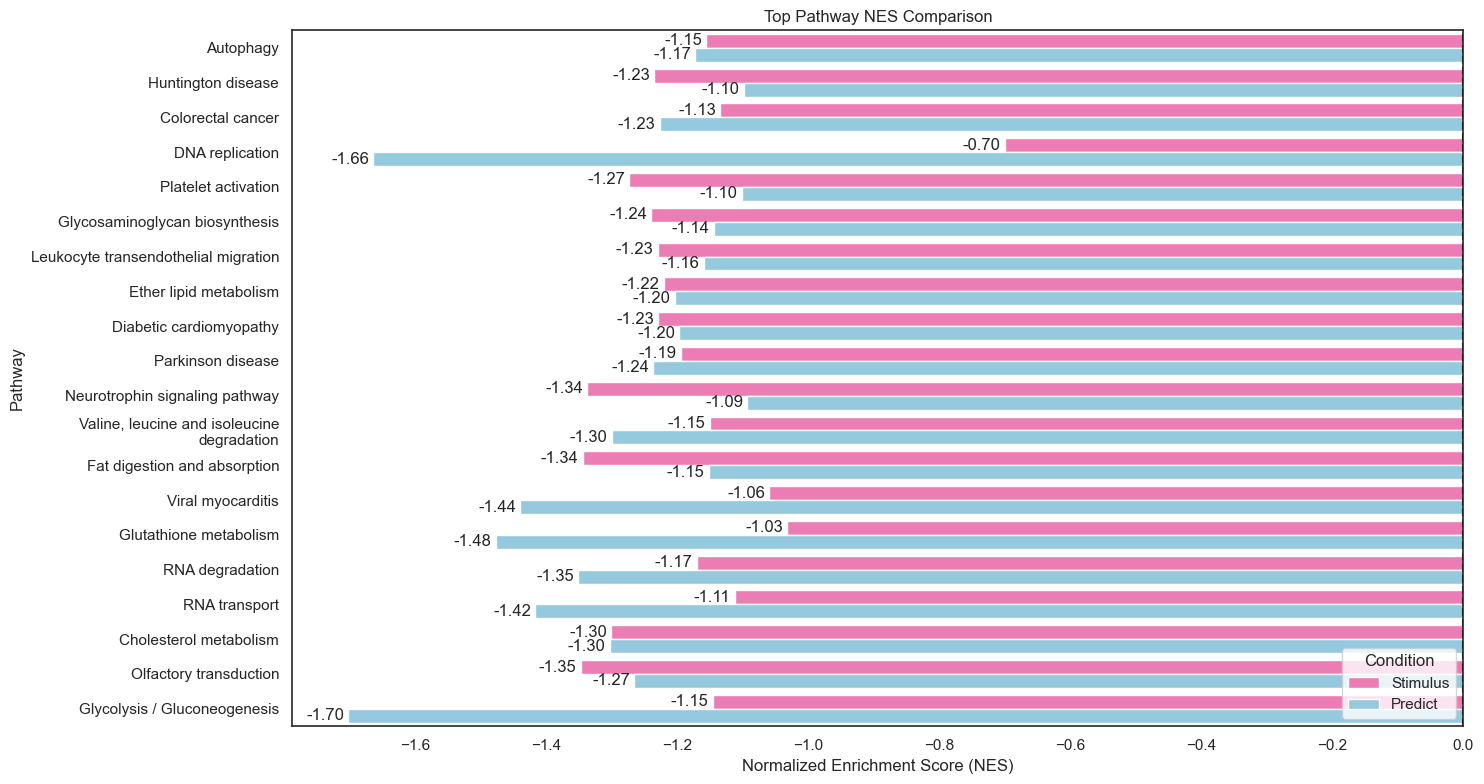

In [ ]:
# 已有的 df_real / df_pred
# df_real = real_gsea.res2d.reset_index().rename(columns={"Term": "Term", "NES": "NES_real"})
# df_pred = pred_gsea.res2d.reset_index().rename(columns={"Term": "Term", "NES": "NES_pred"})

plot_top_common_pathways_from_df(df_real, df_pred, top_n=20)


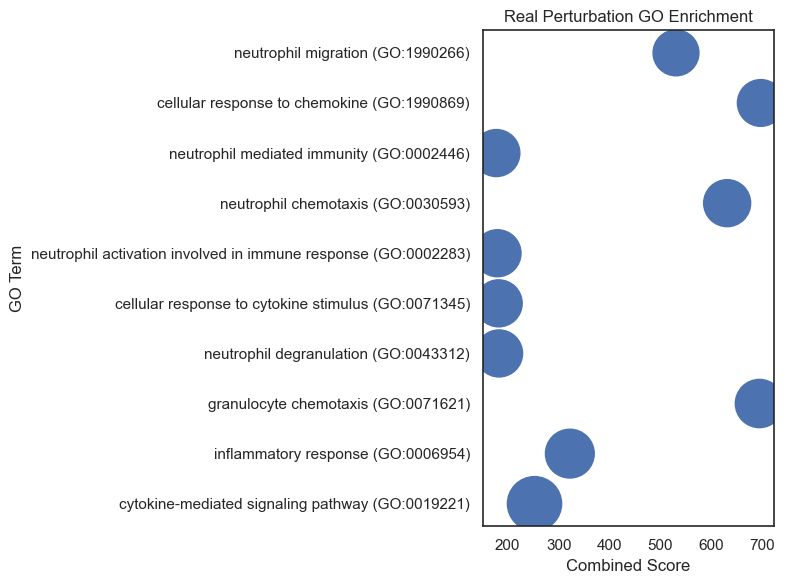

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 选前10个显著GO term
df = real_enrich.results.sort_values('Adjusted P-value').head(10)

plt.figure(figsize=(8, 6))
plt.scatter(df['Combined Score'], df['Term'], s=-np.log10(df['Adjusted P-value'])*100)
plt.xlabel("Combined Score")
plt.ylabel("GO Term")
plt.title("Real Perturbation GO Enrichment")
plt.tight_layout()
plt.show()
